# Training a Multilabel CNN for ECG Classification

<a href='https://link.springer.com/chapter/10.1007/978-3-031-66535-6_30#Tab1'>Link To Article</a>

### Imports:

In [1]:
import os
import keras
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from keras.models import Sequential # type: ignore
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization, Activation # type: ignore

In [2]:
# Importing user-defined module
from Scripts.ptbxl_ml import *
# from Scripts.lead2_ml import *

### Checking For Available GPUs:

In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
if gpus:
    for gpu in gpus:
        print(f'GPU Name: {gpu.name}')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs, ', len(logical_gpus), 'Logical GPUs')

else:
    print('No GPUs found')

No GPUs found


### Loading Preprocessed PTB-XL Dataset:

In [5]:
npz_file = r'Processed Datasets\processed_dataset_12_lead_lr.npz'

In [6]:
ptbxl, signals = load_database(npz_file)

In [7]:
ptbxl[:10]

patient_id   age sex height weight site     device strat_fold  \
1     15709.0  56.0   1    NaN   63.0  0.0  CS-12   E          3   
2     13243.0  19.0   0    NaN   70.0  0.0  CS-12   E          2   
3     20372.0  37.0   1    NaN   69.0  0.0  CS-12   E          5   
4     17014.0  24.0   0    NaN   82.0  0.0  CS-12   E          3   
5     17448.0  19.0   1    NaN   70.0  0.0  CS-12   E          4   
6     19005.0  18.0   1    NaN   58.0  0.0  CS-12   E          4   
7     16193.0  54.0   0    NaN   83.0  0.0  CS-12   E          7   
8     11275.0  48.0   0    NaN   95.0  0.0  CS-12   E          9   
9     18792.0  55.0   0    NaN   70.0  0.0  CS-12   E         10   
10     9456.0  22.0   1    NaN   56.0  0.0  CS-12   E          9   

                                   scp_codes                filename_lr  \
1   {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}  records100/00000/00001_lr   
2               {'NORM': 80.0, 'SBRAD': 0.0}  records100/00000/00002_lr   
3                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00003_lr   
4                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00004_lr   
5                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00005_lr   
6                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00006_lr   
7                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00007_lr   
8     {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}  records100/00000/00008_lr   
9                 {'NORM': 100.0, 'SR': 0.0}  records100/00000/00009_lr   
10                {'NORM': 100.0, 'SR': 0.0}  records100/00000/00010_lr   

   superclasses                                             fields  
1        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
2        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
3        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
4        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
5        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
6        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
7        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
8          [MI]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
9        [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...  
10       [NORM]  {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas...

In [8]:
signals.shape

(21388, 1000, 12)

### Splitting Data into Training and Testing Sets:

In [9]:
# Formatting signals and superclassses
X = signals
Y = ptbxl.loc[:, ['strat_fold', 'superclasses']]

In [10]:
# Training set
x_train = X[np.where(Y.strat_fold < 9)]
y_train = Y[(Y.strat_fold < 9)].superclasses

In [11]:
x_train[:10]

array([[[-1.190e-01, -5.500e-02,  6.400e-02, ..., -2.600e-02,
         -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02, ..., -3.100e-02,
         -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02, ..., -2.800e-02,
         -2.900e-02, -6.900e-02],
        ...,
        [ 6.900e-02,  0.000e+00, -6.900e-02, ...,  2.400e-02,
         -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, ...,  2.420e-01,
         -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02, ...,  1.430e-01,
         -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, ...,  1.920e-01,
          8.300e-02,  8.800e-02],
        [-2.000e-02,  1.160e-01,  1.360e-01, ...,  1.560e-01,
          5.700e-02,  6.300e-02],
        [-5.300e-02,  9.200e-02,  1.450e-01, ...,  1.070e-01,
          1.300e-02,  2.200e-02],
        ...,
        [ 1.210e-01,  3.980e-01,  2.770e-01, ..., -1.065e+00,
         -4.920e-01, -1.560e-01],
        [-3.

In [12]:
y_train[:10]

1     [NORM]
2     [NORM]
3     [NORM]
4     [NORM]
5     [NORM]
6     [NORM]
7     [NORM]
11    [NORM]
12    [NORM]
13    [NORM]
Name: superclasses, dtype: object

In [13]:
# Testing set
x_test = X[np.where(Y.strat_fold >= 9)]
y_test = Y[(Y.strat_fold >= 9)].superclasses

In [14]:
x_test[:10]

array([[[-0.041, -0.08 , -0.039, ..., -0.055, -0.07 , -0.04 ],
        [-0.039, -0.076, -0.037, ..., -0.055, -0.07 , -0.04 ],
        [-0.018, -0.069, -0.051, ..., -0.055, -0.073, -0.045],
        ...,
        [-0.128,  0.368,  0.496, ..., -0.19 , -0.184, -0.004],
        [-0.117,  0.373,  0.491, ..., -0.186, -0.188,  0.002],
        [-0.097,  0.378,  0.474, ..., -0.187, -0.19 , -0.002]],

       [[-0.145, -0.097,  0.049, ..., -0.452, -0.269, -0.032],
        [-0.115, -0.083,  0.032, ..., -0.339, -0.246, -0.041],
        [-0.064, -0.06 ,  0.005, ..., -0.188, -0.199, -0.04 ],
        ...,
        [ 0.23 ,  0.292,  0.063, ...,  0.443,  0.362,  0.222],
        [ 0.251,  0.319,  0.067, ...,  0.498,  0.405,  0.261],
        [ 0.338,  0.361,  0.023, ...,  0.515,  0.447,  0.299]],

       [[-0.065, -0.117, -0.053, ..., -0.118, -0.047, -0.074],
        [-0.067, -0.119, -0.052, ..., -0.11 , -0.043, -0.078],
        [-0.068, -0.133, -0.065, ..., -0.078, -0.033, -0.087],
        ...,
        [-0.

In [15]:
y_test[:10]

8           [MI]
9         [NORM]
10        [NORM]
26        [STTC]
28        [STTC]
30         [HYP]
38        [NORM]
39    [MI, STTC]
40        [NORM]
41          [CD]
Name: superclasses, dtype: object

In [16]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17084, 1000, 12) (17084,)
(4304, 1000, 12) (4304,)


### Converting Superclass Labels into Binary Matrix Format:

In [17]:
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

In [18]:
# Showing original versus encoded labels
print('Classes:', mlb.classes_)

print('\nEncoded Training Labels:\n', y_train[:5])
print('\nOriginal Training Labels:\n', mlb.inverse_transform(y_train[:5]))

print('\nEncoded Testing Labels:\n', y_test[:5])
print('\nOriginal Testing Labels:\n', mlb.inverse_transform(y_test[:5]))

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']

Encoded Training Labels:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]

Original Training Labels:
 [('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',)]

Encoded Testing Labels:
 [[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]

Original Testing Labels:
 [('MI',), ('NORM',), ('NORM',), ('STTC',), ('STTC',)]


In [19]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17084, 1000, 12) (17084, 5)
(4304, 1000, 12) (4304, 5)


### Defining How to Plot Graphs:

In [60]:
def plot_graphs(history, save_path: str) -> None:
    '''
    Plots 3 graphs using a sequential model's history: Training vs. Validation Loss, Training vs. Validation Accuracy,
    and Training vs. Validation AUC.
    
    Args:
        history: A history object (i.e., a record of training and validation metrics)
        save_path: The save path where the loss, accuracy, and AUC figures will be save
    
    Returns:
        None:
    '''
    # Plots training loss versus validation loss
    plt.figure(figsize=(8,4))
    plt.plot(history.epoch, history.history['loss'], 'b', marker='.', label='Training Loss')
    plt.plot(history.epoch, history.history['val_loss'], 'g', marker='.', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(bottom=0.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title('Loss')
    plt.savefig(os.path.join(save_path, 'Loss.png'))
    plt.show()
    
    # Plots training accuracy versus validation accuracy
    plt.figure(figsize=(8,4))
    plt.plot(history.epoch, history.history['Accuracy'], 'b', marker='.', label='Training Accuracy')
    plt.plot(history.epoch, history.history['val_Accuracy'], 'g', marker='.', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(bottom=0.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title('Accuracy')
    plt.savefig(os.path.join(save_path, 'Accuracy.png'))
    plt.show()
    
    # Plots training area under curve versus validation area under curve
    plt.figure(figsize=(8,4))
    plt.plot(history.epoch, history.history['AUC'], 'b', marker='.', label='Training AUC')
    plt.plot(history.epoch, history.history['val_AUC'], 'g', marker='.', label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC Score')
    plt.ylim(bottom=0.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title('AUC')
    plt.savefig(os.path.join(save_path, 'AUC.png'))
    plt.show()

### Defining Functions for Evaluating the Model:

In [21]:
def evaluate_model(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray) -> list[float]:
    '''
    Evaluates a pre-trained model on the test data provided.
    
    Args:
        model: The pre-trained model to be evaluated
        test_data: A matrix of shape (n_samples, n_time_points)
        test_labels: The labels corresponding the the test/validation dataset
        
    Returns:
        tuple: A two-element tuple, containing the model's loss and accuracy scores
    '''
    score = model.evaluate(test_data, test_labels, verbose=1)
    
    print(f'\nLoss On Test Data: {score[0]:.2f}')
    print(f'\nAccuracy On Test Data: {score[1]:.2f}')
    
    return score

In [22]:
def model_predict(model: keras.Sequential, test_data: np.ndarray, test_labels: np.ndarray, threshold: float=0.5) -> tuple[np.ndarray, np.ndarray]:
    '''
    Generates predictions using the inputted model and test data. The threshold specified will determine if a certain 
    superclass/label is present within a record.
    
    Args:
        model: The pre-trained model that will be generating the predictions
        test_data: A matrix of shape: (n_samples, n_time_points)
        test_labels: The labels corresponding to the test/validation dataset
        threshold: Determines the minimum value for considering a superclass present
        
    Returns:
        tuple: A two-element tuple containng the ground truth labels and the model's predicted labels
    '''
    y_test_pred = model.predict(test_data)
    
    # Converts probabilites into binary labels (i.e. either 0 or 1 if they meet the threshold)
    y_hat = (y_test_pred >= threshold).astype(int)
    
    # Ensures test data is in binary format
    y_test = test_labels.astype(int)
    
    return (y_test, y_hat)

In [ ]:
def show_confusion_matrix(test_labels: np.ndarray, prediction_labels: np.ndarray, classes: np.ndarray, save_path: str) -> list:
    '''
    Visualizes the performance of a model via confusion matrices and heatmaps. A 2x2 confusion matrix is plotted and 
    displayed for each class.
    
    Args:
        test_labels: The ground truth labels
        prediction_labels: The generated labels predicted by a pre-trained model
        classes: The labels of the unique superclasses within the dataset (i.e., [CD, HYP, MI, NORM, STTC])
        save_path: The save path where all confusion matrices will be saved
    
    Returns:
        list: A list containing figures corresponding to each superclass
    '''
    figures = []
    
    cm_save_path = os.path.join(save_path, 'confusion_matrices')
    os.makedirs(cm_save_path, exist_ok=True)
    
    # Computes the confusion matrix for each individual class
    matrices = multilabel_confusion_matrix(test_labels, prediction_labels)
    
    for i, label in enumerate(classes):
        
        plt.figure(figsize=(6,4))
        
        sns_hm = sns.heatmap(matrices[i],
                            cmap='YlGnBu',
                            linecolor='white',
                            xticklabels=['Negative', 'Positive'],
                            yticklabels=['Negative', 'Positive'],
                            annot=True, # ensures values are on heatmap
                            fmt='d') # formats values as ints
        
        plt.title(f'{label} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        figure = sns_hm.get_figure()
        figures.append(figure)
        plt.savefig(os.path.join(cm_save_path, f'{label}_cm.png'))
        plt.show()
        
    return figures

### Generating the CNN Model:

In [24]:
def generate_1D_model() -> keras.Sequential:
    '''
    Generates and returns a Keras sequential CNN model with 7 convolutional blocks. The initial 6 blocks consist of 1D 
    convolutional layers with ReLU activation, batch normalization, max pooling, and dropout layers. The final block
    implements a 1D convolutional layer, however, it performs global average pooling and has a larger droput value.
    
    Args:
        None:
        
    Returns:
        keras.Sequential: The model generated
    '''
    model = Sequential([Input(shape=(1000, 12))])
    
    # Convolutional Block 1
    model.add(Conv1D(32, 3, name='conv1', input_shape=(1000,12)))
    model.add(BatchNormalization(name='bn1'))
    model.add(Activation('relu', name='relu1'))
    model.add(MaxPooling1D(2, name='max1'))
    model.add(Dropout(0.2, name='drop1'))
    
    # Convolutional Block 2
    model.add(Conv1D(64, 3, name='conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Activation('relu', name='relu2'))
    model.add(MaxPooling1D(2, name='max2'))
    model.add(Dropout(0.2, name='drop2'))
    
    # Convolutional Block 3
    model.add(Conv1D(128, 3, name='conv3'))
    model.add(BatchNormalization(name='bn3'))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling1D(2, name='max3'))
    model.add(Dropout(0.2, name='drop3'))
    
    # Convolutional Block 4
    model.add(Conv1D(256, 3, name='conv4'))
    model.add(BatchNormalization(name='bn4'))
    model.add(Activation('relu', name='relu4'))
    model.add(MaxPooling1D(2, name='max4'))
    model.add(Dropout(0.2, name='drop4'))
    
    # Convolutional Block 5
    model.add(Conv1D(512, 3, name='conv5'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Activation('relu', name='relu5'))
    model.add(MaxPooling1D(2, name='max5'))
    model.add(Dropout(0.2, name='drop5'))
    
    # Convolutional Block 6
    model.add(Conv1D(1024, 3, name='conv6'))
    model.add(BatchNormalization(name='bn6'))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling1D(2, name='max6'))
    model.add(Dropout(0.2, name='drop6'))
    
    # Convolutional Block 7
    model.add(Conv1D(2048, 3, name='conv7'))
    model.add(BatchNormalization(name='bn7'))
    model.add(Activation('relu', name='relu7'))
    model.add(GlobalAveragePooling1D(name='gap1'))
    model.add(Dropout(0.5, name='drop7'))
    
    # Dense Layer
    model.add(Dense(5, name='dense1', activation='sigmoid'))
    
    return model

### Defining Callback Methods for Model Traning:

In [ ]:
# Checkpoint folder
chkpt_folder = os.path.join(os.getcwd(), r'training_sessions\session_6')

# Checkpoint path
chkpt_path = os.path.join(chkpt_folder, 'weights', 'CustomCNN_12Lead_{epoch}.weights.h5')

# Ensuring path exists
os.makedirs(chkpt_path, exist_ok=True)

In [66]:
print(chkpt_folder)
print(chkpt_path)

c:\Users\loera\Documents\Multilabel-ECG-Classification\training_sessions\session_6
c:\Users\loera\Documents\Multilabel-ECG-Classification\training_sessions\session_6\weights\CustomCNN_12Lead_{epoch}.weights.h5


In [27]:
# Defining how to save model training checkpoints
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=chkpt_path,
                                                            save_weights_only=True,
                                                            monitor='val_Accuracy',
                                                            mode='max', # want the max accuracy
                                                            save_best_only=True,
                                                            verbose=1) # prints message for saved weights

### Compiling and Training the Model:

In [28]:
# model = generate_1D_model()

In [29]:
def generate_12lead_model(input_shape: tuple=(1000,12), n_outputs: int=5):
    model = Sequential([
        Input(shape=input_shape),
        # Block 1: Per-lead temporal modeling
        Conv1D(36, 15, padding='same', groups=12, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        
        # Learnable downsampling
        Conv1D(64, 7, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        
        # Block 2: Cross-lead fusion
        Conv1D(128, 7, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        
        Conv1D(128, 5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        
        # Block 3: Deep abstraction
        Conv1D(256, 5, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        
        # Embedding head
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_outputs, activation='sigmoid')
    ])
    return model

In [30]:
model = generate_12lead_model()

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1000, 36)       │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 36)       │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1000, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 128)       │        57,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 250, 128)       │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 250, 256)       │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 250, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,89

 Total params: 355,761 (1.36 MB)

 Trainable params: 354,537 (1.35 MB)

 Non-trainable params: 1,224 (4.78 KB)

In [32]:
# Compiling the model
model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                         keras.metrics.Recall(name='Recall'),
                         keras.metrics.Precision(name='Precision'),
                         keras.metrics.AUC(name='AUC', multi_label=True, num_labels=5)])

In [33]:
# Training the model
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_test, y_test),
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - AUC: 0.5575 - Accuracy: 0.6792 - Precision: 0.3920 - Recall: 0.3763 - loss: 0.6166
Epoch 1: val_Accuracy improved from -inf to 0.74080, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\training_sessions\session_5\CustomCNN_12Lead_1.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - AUC: 0.5590 - Accuracy: 0.6805 - Precision: 0.3939 - Recall: 0.3742 - loss: 0.6154 - val_AUC: 0.5874 - val_Accuracy: 0.7408 - val_Precision: 0.5000 - val_Recall: 1.7928e-04 - val_loss: 0.6324
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - AUC: 0.7434 - Accuracy: 0.7840 - Precision: 0.7071 - Recall: 0.2906 - loss: 0.4836
Epoch 2: val_Accuracy did not improve from 0.74080
34/34 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - AUC: 0.7441 - Accuracy: 0.7842 - Precision: 0.7072 - Recall: 0.2920 - loss: 0.4831 - val_AUC: 0.6032 - val_Accuracy: 0.7396 - val_Precision: 0.1750 - val_Recall: 0.0013 - val_loss: 0.6119
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━

### Evaluating the Model:

In [34]:
print('Evaluating Model:\n')
scores = evaluate_model(model=model, test_data=x_test, test_labels=y_test)

Evaluating Model:

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.9118 - Accuracy: 0.8805 - Precision: 0.8043 - Recall: 0.7092 - loss: 0.3487

Loss On Test Data: 0.36

Accuracy On Test Data: 0.87


In [35]:
print('Generating Model Predictions:\n')
y_test, y_hat = model_predict(model=model, test_data=x_test, test_labels=y_test)

Generating Model Predictions:

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


### Plotting Model's Training Log:

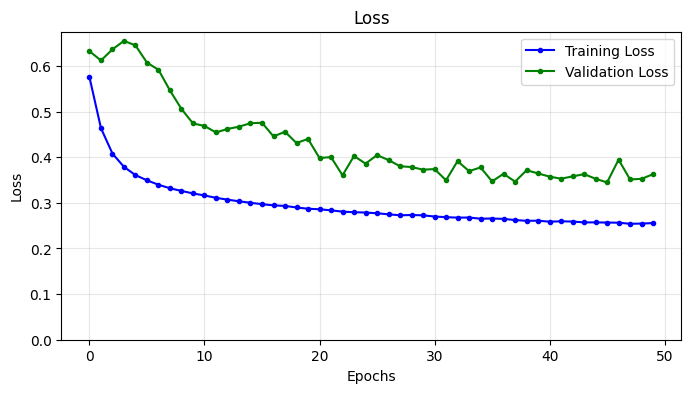

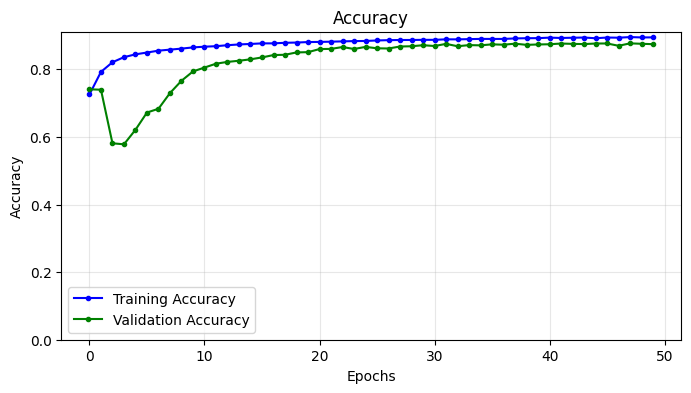

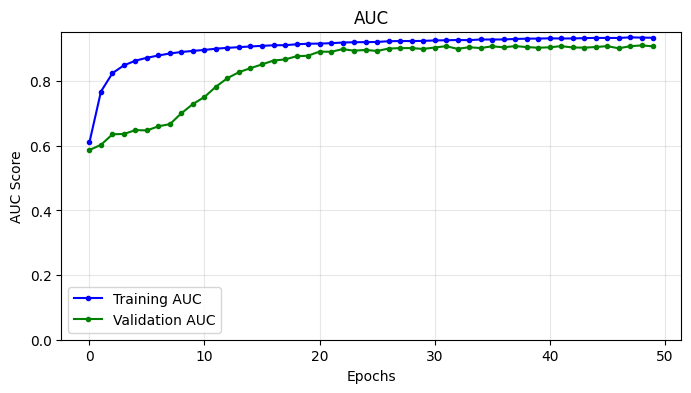

In [64]:
plot_graphs(history, chkpt_folder)

### Computing Confusion Matrices:

In [37]:
matrix_labels = mlb.classes_

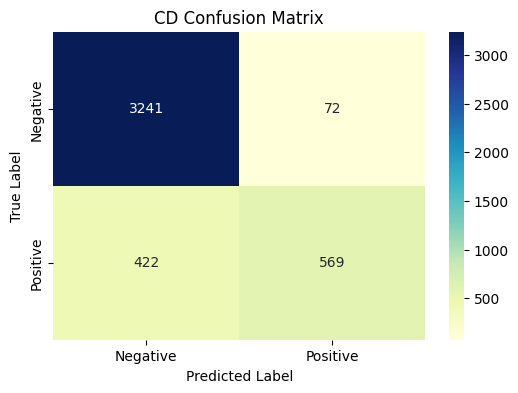

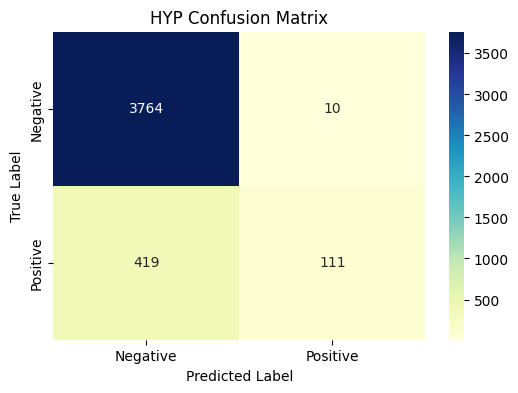

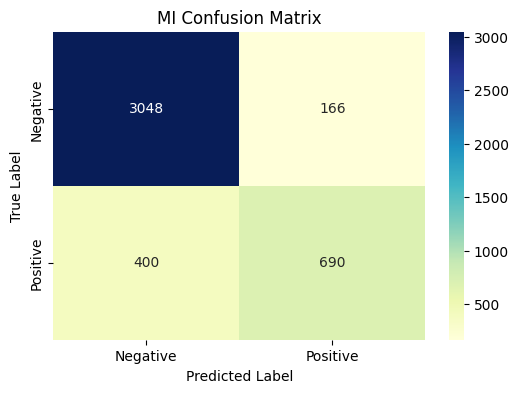

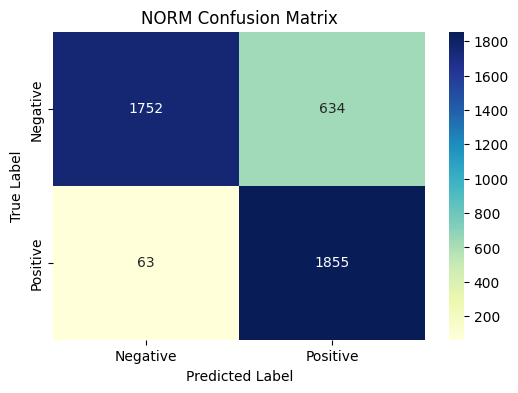

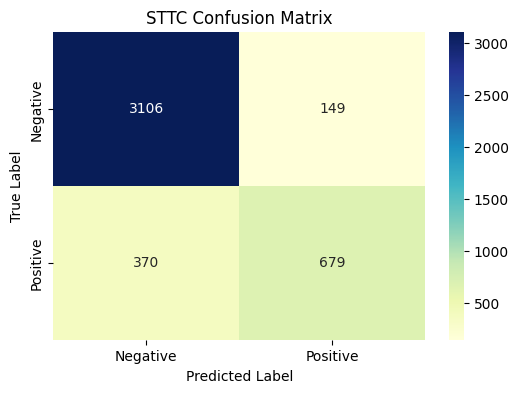

In [38]:
conf_matrix = show_confusion_matrix(y_test, y_hat, matrix_labels, chkpt_folder)

### Computing Classification Report:

In [39]:
class_report = classification_report(y_test, y_hat, target_names=matrix_labels)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
print(class_report)

              precision    recall  f1-score   support

          CD       0.89      0.57      0.70       991
         HYP       0.92      0.21      0.34       530
          MI       0.81      0.63      0.71      1090
        NORM       0.75      0.97      0.84      1918
        STTC       0.82      0.65      0.72      1049

   micro avg       0.79      0.70      0.74      5578
   macro avg       0.84      0.61      0.66      5578
weighted avg       0.81      0.70      0.72      5578
 samples avg       0.78      0.74      0.74      5578

